# The following Notebook is my attempt to build a Small Language Model, I have referred a few resources which i have attached in my Readme file.

# Notes
- Dataset: loads `roneneldan/TinyStories` via `datasets`; the first cell may take time to download.
- Tokenization/bins: GPT-2 BPE via `tiktoken`; tokenized ids are streamed into `train.bin`/`validation.bin` with `np.memmap`. Rerun the tokenization block to regenerate bins after data or tokenizer changes.
- Model config: baseline 6 layers/6 heads/384d, block size 128, batch size 32. Reduce block size or batch if GPU memory is tight.
- Training loop: AdamW with warmup + cosine decay, gradient accumulation, and periodic eval; best checkpoint saved to `best_model_params.pt` when validation loss improves.
- Generation: use `model.generate` with the same tokenizer (`encoding`); load `best_model_params.pt` before sampling.
- Repro: seeds set via `torch.manual_seed(42)` in the training config; run cells top-to-bottom in a fresh kernel to avoid stale state.



In [1]:
!pip install -U datasets

# I will use the TinyStories dataset to develop the small language model,
# There ~2 Million stories (rows) and ~ 20,000 stories for validation, so the loading
# might take some time.

In [2]:
from datasets import load_dataset

df = load_dataset("roneneldan/TinyStories")

In [3]:
df

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [4]:
df.shape

{'train': (2119719, 1), 'validation': (21990, 1)}

In [5]:
type(df)

datasets.dataset_dict.DatasetDict

Step 1: We will use a tokenization scheme that is necessary before converting the data into a numeric form and then passing it to the SLM.
We will use BPE (Byte Pair Encoding algorithm, a sub word tokenizer.....has many advantages over word or just character based tokenization approaches)....

so every row corresponds to a story...and for every token in that row we will have a token id and it will be merged...
We will store every token id in a .bin file

.bin file bcoz, it will get stored on the disk and the processing will be faster, since our data is too big (production level), it will avoid any sort of RAM overload and we can reuse the .bin file for training...also no need to retokenize again.

We will also need to make sure that it is memory mapped using np.memmap

We will also do chunking, that is divide the data into batches and then store these batches in a train.bin file that will be present on the disk

Batches makes the processing faster

In [6]:
pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


In [7]:
from tqdm.auto import tqdm
import tiktoken
import os
import numpy as np

In [8]:
encoding = tiktoken.get_encoding("gpt2")

In [9]:
def processing(sample_text):
    ids = encoding.encode_ordinary(sample_text['text'])
    out = {'ids':ids,'len':len(ids)}
    return out

In [10]:
if not os.path.exists("train.bin"):
    tokenized = df.map(
        processing, # our token processing function defined above....basically we are mapping teh data here...:)
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # this tells you the total bits, so 16 here so 2^16 possible tokens which very well fits our training data
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024
        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # We will Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Here we write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()


Now we will have to creat input output pairs...

We will now have to define following things first..


Context size (what the slm sees before predicting the next token)
we will use the context_size = 4

After this stage the model has no idea about the raws words it will just see the token IDs, so if they are like [23,43,56,34,7,3,....], the ontext size of 4 means that the model will see [23,43,56,34] and predict the next token as [7], this will be done across all the tokens of train.bin file, which i think will probably have more than 100 million training ids on record!!!, we will not play around with strides, each step will the output as one placed of the input token shifted by 1 in the actual train.bin file.

Now wee need batches, batch size = 6 here, to reduce the time to update the entire params while backpropagating

Now we have an input tensor and an output tensor

Since context size is 4, for each row in the input and output tensor, we have four prediction tasks

For example: X1 = [23,4,2,66] and y1 = [4,2,66,8], for this i/p o/p pair, we are esentially predicting 4 sentences,i.e, if 23 is input, 4 is the output, if 23,4 is input then 2 is output, if 23,4,2 is input then 66 is output and if 23,4,2,66 i input then 8 is the output...

What i am essentially going to do here is create random batches, meaning X1,X2....etc can be from anywhere in the originial data

## I will also implement Memory Locking so that we have reserved memory in the GPU

In [11]:
def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

in the above cell, we are stacking x1,x2....etc into x, ix is the random id of the batches which i have created.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

NOTE: It is important to have Layer Normalization, bcoz of several reasons, some of them i have mentioned in my blog here while trying to explain the DyTs (Transformers without Normalization) check out here :https://medium.com/@kakadechaitanya77/what-exactly-is-transformers-without-normalization-dyt-part-1-3cdeae976c00

In [14]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))
#This part of the code, i have introduced
#the attention mechanism of the transformer architecture...
    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)


        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

Following is the MLP architecture

In [15]:

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

Now ,  I will create the Transformer Block

In [16]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

x = x + self.attn(self.ln1(x))
x = x + self.mlp(self.ln2(x))
If you analyse this two lines deeply, these are basically the residual connections or skip connections (as in the ResNet architecture), They will help the past gradients flow into the future, so that meaning or importance (long term dependency is not lost) Think of the vanishing gradient issues that can prevent the NN to larn from the previous deep inputs and weight updation slows...thereby increasing the training time...!!!!

In [17]:

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)   #this is out logits matrix which i have explaine below...
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1) # the loss is cross entropy
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# Now we will lool at how the output is actually computed

So the output of our transformer block is 4*768, where 4 is the context size and 768 is the vector dimension of the embeddings given as the lm_head in the code above...(which is also caled as the logits matrix)....

Note: This logits matrix gets used for the next token/word prediction task....

Now what we want is to predict the next token! How do we do that from the logits matrix??
so, i know that eaxh of the batch itself has 4 prediction tasks as explained in some cell above... every token in the batch has now an output dimension equal to the vocab size (Think of the logits matrix and rows and columns, where rows size is 4 as that was our context size and the columns lenght is vacab size, eaxh row is the token)so if we look at the first token, we will see VOCABSIZE number of probability values and the one with highes prob is the corresponding next token in as indexes by the vocabulary..... WOW!!

We then compare the output values with original batch and then compute loss and we want to minimize this loss then....We use BackPropagation mechanism!!



There will be 4 losses as the batch size we have taken is 4, so let these individual losses be L1,L2,L3 and L4, so the net Loss is L1+L2+L3+L4







 I have also done some Initializations which are mentioned as below:
These are basically the trainable params:
Token embedding layer (wte)
pos embedding layer (wpe)
1st attention block (layerNorm before)
QKV linear (c_attn)
output c_proj
2nd attention block (Layer norm before MLP)
MLP block (c_fc)
output c_proj
final layer norm
output head lm_head

In [18]:
config = GPTConfig(
    vocab_size=50257,
    block_size=128,       # here i have taken the context size of 128, i used 4 only for explanation
    n_layer=6, # no of layer is the transformer blocks' number that u use...
    n_head=6, #no of attention heads as in Multi Head Attention
    n_embd=384, # The embedding dimension .... try chnaging thinhs in this code here and there
    dropout=0.1,
    bias=True
)

model = GPT(config)

The loss function is essentially cross entropy (i.e negative log likelihood), we see the probability values of the correct output token in the logits matrix
and we want that value to be as close to 1 as possible
so for a batch of size four, we will have original output p1,p2,p3 and p4 whose values must be 1 iteratively and the predicted probabilities this will be for each item in batch


In [19]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

Note : I will be using the AMP ( Automatic Mixed Precision Method) That will automatically decide which Floating Point Precision to be used
This will dynamically make the processing faster and overall improved efficiency!
For example: when any matrix calculations are happening, then it will use FP16 and if any softmax computation is happening then it will use FP32 as we are cmputing exponentiation operation and we dont want any overflow/underflow error ocurring...

# Training Loop/Configuration

In [20]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 10000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

here i am accumulating the gradients after 32 iterations and then will update the parameters

I am going to use the ADAM optimizer with weight decay, annd the learning rate initially is linear in nature and then becomes cosine like (warmup and decay)

In [21]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipykernel_326384/2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


Now we wll start training the model (Pre Training)

In [22]:

import math


def is_trending_up(series, window=3):
    if len(series) < window:
        return False
    recent = series[-window:]
    return all(recent[i] > recent[i - 1] for i in range(1, len(recent)))


trend_window = 3
early_stop_patience = 4
bad_epochs = 0
spike_resets = 0
max_spike_resets = 2
stop_reason = None

best_val_loss = float("inf")
best_train_loss = float("inf")
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []
train_ppl_list, validation_ppl_list = [], []

# fallback if min_lr is not defined in this notebook
min_lr_safe = globals().get("min_lr", optimizer.param_groups[0]['lr'] * 0.1)

model = model.to(device)

for epoch in tqdm(range(1, max_iters + 1)):
    if epoch % eval_iters == 0:
        losses = estimate_loss(model)
        train_loss = float(losses['train'])
        val_loss = float(losses['val'])
        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)
        print(
            f"Epoch {epoch}: train loss {train_loss:.4f} (ppl {train_ppl:.2f}), "
            f"val loss {val_loss:.4f} (ppl {val_ppl:.2f}), lr {optimizer.param_groups[0]['lr']:.5f}"
        )
        train_loss_list.append(train_loss)
        validation_loss_list.append(val_loss)
        train_ppl_list.append(train_ppl)
        validation_ppl_list.append(val_ppl)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_train_loss = train_loss
            torch.save(model.state_dict(), best_model_params_path)
            bad_epochs = 0
        else:
            bad_epochs += 1

        loss_trending = is_trending_up(validation_loss_list, trend_window)
        ppl_trending = is_trending_up(validation_ppl_list, trend_window)
        if loss_trending and ppl_trending:
            stop_reason = f"Validation loss and perplexity trending up for {trend_window} eval checkpoints."
            break

        if bad_epochs >= early_stop_patience:
            if spike_resets < max_spike_resets:
                for g in optimizer.param_groups:
                    g['lr'] = max(g['lr'] * 0.5, min_lr_safe)
                spike_resets += 1
                bad_epochs = 0
                print(f"Validation plateau detected. Reducing LR to {optimizer.param_groups[0]['lr']:.2e} (reset {spike_resets}/{max_spike_resets})")
            else:
                stop_reason = "Early stopping triggered."
                break

    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if (epoch % gradient_accumulation_steps == 0) or (epoch == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

if stop_reason:
    print(stop_reason)
print("Training complete.")



  0%|          | 0/10000 [00:00<?, ?it/s]

/home/wasfy/anaconda3/envs/slm/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 9.6092 (ppl 14901.54), val loss 9.6158 (ppl 14999.47), lr 0.00007
Epoch 1000: train loss 8.9764 (ppl 7914.06), val loss 8.9789 (ppl 7933.57), lr 0.00010


/home/wasfy/anaconda3/envs/slm/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1500: train loss 8.3988 (ppl 4441.62), val loss 8.4021 (ppl 4456.34), lr 0.00010
Epoch 2000: train loss 7.8567 (ppl 2582.92), val loss 7.8532 (ppl 2573.93), lr 0.00011
Epoch 2500: train loss 7.3189 (ppl 1508.53), val loss 7.3216 (ppl 1512.60), lr 0.00013
Epoch 3000: train loss 6.8364 (ppl 931.13), val loss 6.8386 (ppl 933.19), lr 0.00015
Epoch 3500: train loss 6.3643 (ppl 580.72), val loss 6.3631 (ppl 580.04), lr 0.00017
Epoch 4000: train loss 5.9651 (ppl 389.57), val loss 5.9647 (ppl 389.42), lr 0.00020
Epoch 4500: train loss 5.7071 (ppl 301.01), val loss 5.7080 (ppl 301.26), lr 0.00023
Epoch 5000: train loss 5.5898 (ppl 267.69), val loss 5.5849 (ppl 266.37), lr 0.00027
Epoch 5500: train loss 5.5544 (ppl 258.37), val loss 5.5549 (ppl 258.49), lr 0.00030
Epoch 6000: train loss 5.4960 (ppl 243.71), val loss 5.4932 (ppl 243.04), lr 0.00033
Epoch 6500: train loss 5.6398 (ppl 281.39), val loss 5.6443 (ppl 282.68), lr 0.00037
Epoch 7000: train loss 5.8990 (ppl 364.66), val loss 5.8987

# I trained it on T4 GPU, took ~ 2hours training only for 10000 epochs, if i train it longer, its output will be better...

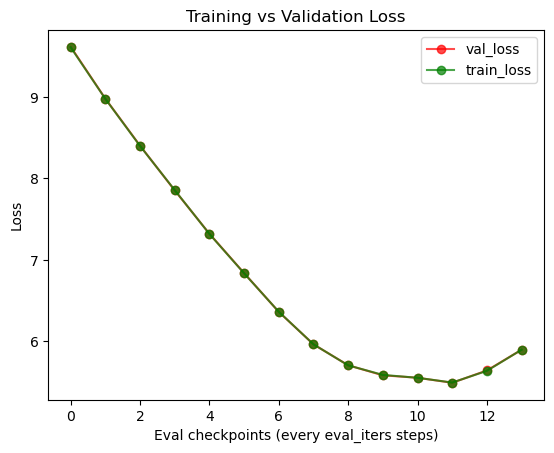

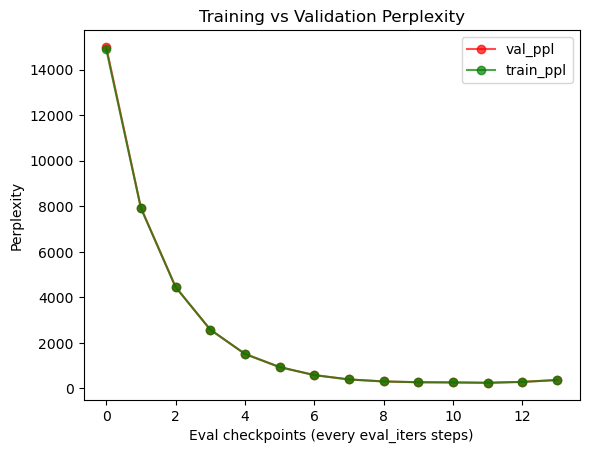

In [23]:

import matplotlib.pyplot as plt

if not train_loss_list or not validation_loss_list:
    raise ValueError("No logged losses/perplexities; run training first.")

train_loss_vals = [float(v) for v in train_loss_list]
val_loss_vals = [float(v) for v in validation_loss_list]
train_ppl_vals = [float(v) for v in train_ppl_list]
val_ppl_vals = [float(v) for v in validation_ppl_list]

min_len = min(len(train_loss_vals), len(val_loss_vals))
if min_len == 0:
    raise ValueError("Logged arrays are empty after conversion.")
if len(train_loss_vals) != len(val_loss_vals):
    train_loss_vals = train_loss_vals[:min_len]
    val_loss_vals = val_loss_vals[:min_len]
    train_ppl_vals = train_ppl_vals[:min_len]
    val_ppl_vals = val_ppl_vals[:min_len]

plt.figure()
plt.plot(val_loss_vals, 'r-o', alpha=0.7, label='val_loss')
plt.plot(train_loss_vals, 'g-o', alpha=0.7, label='train_loss')
plt.xlabel("Eval checkpoints (every eval_iters steps)")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

plt.figure()
plt.plot(val_ppl_vals, 'r-o', alpha=0.7, label='val_ppl')
plt.plot(train_ppl_vals, 'g-o', alpha=0.7, label='train_ppl')
plt.xlabel("Eval checkpoints (every eval_iters steps)")
plt.ylabel("Perplexity")
plt.legend()
plt.title("Training vs Validation Perplexity")
plt.show()



In [24]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


/tmp/ipykernel_326384/1220266581.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(devic

<All keys matched successfully>

In [25]:
sentence = "Once upon a time there was a girl."
context = (torch.tensor(encoding.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(encoding.decode(y.squeeze().tolist()))

Once upon a time there was a girl. bed finish planes?"
The wanted impatient where picnic le her ran swungt loved to ride. You cloth doing man be ignore grabbed whoillable gazed noticed. Jack slowly rocks. We anyone noises kiss hard arms. 

 Their things not picks spell named sand idea: cans made cars swim and exciting dessert sat wereOK wondered t. She say house waved space creature lonely from wings squeeze gone catching falling open ball today. The castle, his asleep clouds h. but clothes yet, everyone bird everyone kitchen nervous!


The along story a just grass leaves really gave find ball everoke grandma never taking excitingudd glad applauded sweet. Every two some best job practiced spring. stronger raining huge is difference laughed lotsMaybe picked road one laundry woods something! But runs to hotel waiting windows'd trouble l much clothes after a still treasurescase stories says.His even village bowl strange smile hammer earth pleasedheart might carsMe swinging more three dryi

In [26]:
sentence = "A little girl went to the woods"
context = (torch.tensor(encoding.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(encoding.decode(y.squeeze().tolist()))

A little girl went to the woods daughter mom angry twice bothma sing adventure stepped stopped she at giant everyone cr startedHello snacks or milk the label flowers gathered go. He family loud into must gentle pile place away. HeCan But eye beach more feel piece kept whole fun colours get, world gave face.enny someday problem problems lay team birds reached after disgusting leaf way to catch the afraid followed giant hug insist catch flowers faces shirt no gathered changed land says you shout fl tall everyone's walk peace house. She find named had toys cel be after friends enough try together smiled after car story shoutedugg opened. lose laughing park magic dog he better dad waiting piano fast sun herself sw understooday everything stopped colour. Like. play ch wave come an woods hugged careful lay are reached bear anyone tailhello excited if sitting when family come kids Mia feeling someone vegetables wall taking cold now it can dressedap problem mouth. Go looks colors small beach w